In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
basedir_npz = "/home/domainHomes/ssakharov/master_thesis/crossdocked/processed_crossdock_noH_ca_only_temp/"
train_npz = basedir_npz + "/train.npz"
test_npz = basedir_npz + "/test.npz"
torch.manual_seed(42)

### So let's start with a dataset
    1) as wee see we have 99929 samples, each sample has different number of atoms, that is why the data is stored as a list of torch tensors
    2) If center == True, the data is centered around the center of mass of the molecule (sum of all atoms divided by the number of atoms for each axis, then subtracted from each atom position)
    3) Currentrly no idea what transform does, because virtual_nodes are not defined in the main file and set to False by default in the dataset class


In [2]:
from dataset import ProcessedLigandPocketDataset

train_dataset = ProcessedLigandPocketDataset(npz_path=train_npz, transform=None, center=False)
# test_dataset = ProcessedLigandPocketDataset(npz_path=test_npz, transform=None, center=False)
print(train_dataset.data.keys())
print(train_dataset.data["num_pocket_nodes"][:5])
print(train_dataset.data["num_lig_atoms"][:5])
for item in train_dataset.data:
    print(item, len(train_dataset.data[item]))
    break

dict_keys(['names', 'lig_coords', 'lig_one_hot', 'lig_mask', 'num_lig_atoms', 'pocket_coords', 'pocket_one_hot', 'pocket_mask', 'num_pocket_nodes'])
tensor([48, 42, 42, 36, 49])
tensor([26, 31, 19, 22, 19])
names 99929


    In this example we can see how the centering works

tensor([-14.0012,  18.3472,   8.1275], dtype=torch.float64)


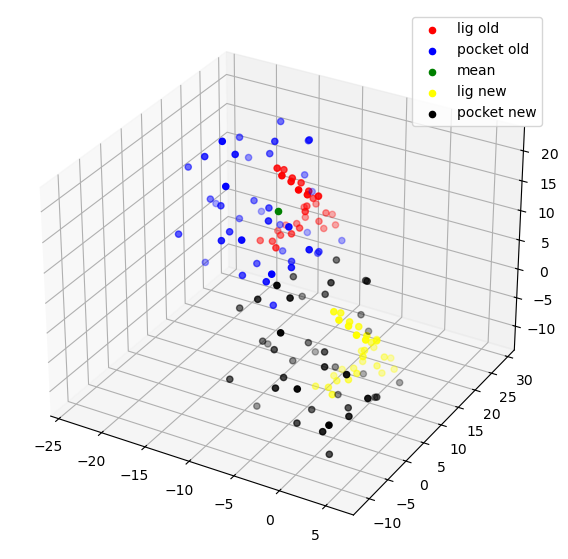

In [3]:
for i in range(len(train_dataset.data['lig_coords'])):
    # print(train_dataset.data['lig_coords'][i].shape)
    # print(train_dataset.data['lig_coords'][i].sum(0).shape)
    mean = (train_dataset.data['lig_coords'][i].sum(0) +
                        train_dataset.data['pocket_coords'][i].sum(0)) / \
                       (len(train_dataset.data['lig_coords'][i]) + len(train_dataset.data['pocket_coords'][i]))
    # print(mean)
    if mean.sum()>1:
        print(mean)
        new_lig_coords = train_dataset.data['lig_coords'][i] - mean
        new_pocket_coords = train_dataset.data['pocket_coords'][i] - mean
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(train_dataset.data['lig_coords'][i][:,0], train_dataset.data['lig_coords'][i][:,1], train_dataset.data['lig_coords'][i][:,2], c='r', marker='o', label='lig old')
        ax.scatter(train_dataset.data['pocket_coords'][i][:,0], train_dataset.data['pocket_coords'][i][:,1], train_dataset.data['pocket_coords'][i][:,2], c='b', marker='o', label='pocket old')
        ax.scatter(mean[0], mean[1], mean[2], c='g', marker='o', label='mean')
        ax.scatter(new_lig_coords[:,0], new_lig_coords[:,1], new_lig_coords[:,2], c='yellow', marker='o', label='lig new')
        ax.scatter(new_pocket_coords[:,0], new_pocket_coords[:,1], new_pocket_coords[:,2], c='black', marker='o', label='pocket new')
        plt.legend()
        plt.show()

        break

### Now lets see the Dataloader
    1) the custom collate_fn for batching is used: each sample consist of different number of atoms, so we need to use masking as previously.

In [4]:
from torch.utils.data import DataLoader
trainloader = DataLoader(train_dataset, 3, shuffle=False,
                          collate_fn=train_dataset.collate_fn,
                          pin_memory=True)

In [5]:
item = next(iter(trainloader))
print(item.keys())
print(f"item['lig_coords'].shape {item['lig_coords'].shape}")
print(f"item['lig_one_hot'].shape {item['lig_one_hot'].shape}")
print(f"item['pocket_one_hot'].shape {item['pocket_one_hot'].shape}")
for idx in np.unique(item['lig_mask']):
    print(f"Number of atoms in ligand {int(idx)}: {np.array((item['lig_mask']==idx)).sum()}")
    print(f"Number of atoms in pocket {int(idx)}: {np.array((item['pocket_mask']==idx)).sum()}")
item['lig_mask']

dict_keys(['names', 'lig_coords', 'lig_one_hot', 'lig_mask', 'num_lig_atoms', 'pocket_coords', 'pocket_one_hot', 'pocket_mask', 'num_pocket_nodes'])
item['lig_coords'].shape torch.Size([76, 3])
item['lig_one_hot'].shape torch.Size([76, 10])
item['pocket_one_hot'].shape torch.Size([132, 20])
Number of atoms in ligand 0: 26
Number of atoms in pocket 0: 48
Number of atoms in ligand 1: 31
Number of atoms in pocket 1: 42
Number of atoms in ligand 2: 19
Number of atoms in pocket 2: 42


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2.])

### Let's go to training and especially to the forward function

    fisrly separete the data into ligands and pockets

In [6]:
from constants import FLOAT_TYPE, INT_TYPE
### FLOAT_TYPE = torch.float32
### INT_TYPE = torch.int64
def get_ligand_and_pocket(data):
    device = "cpu"
    ligand = {
        'x': data['lig_coords'].to(device, FLOAT_TYPE),
        'one_hot': data['lig_one_hot'].to(device, FLOAT_TYPE),
        'size': data['num_lig_atoms'].to(device, INT_TYPE),
        'mask': data['lig_mask'].to(device, INT_TYPE),
    }

    pocket = {
        'x': data['pocket_coords'].to(device, FLOAT_TYPE),
        'one_hot': data['pocket_one_hot'].to(device, FLOAT_TYPE),
        'size': data['num_pocket_nodes'].to(device, INT_TYPE),
        'mask': data['pocket_mask'].to(device, INT_TYPE)
    }
    return ligand, pocket

ligand, pocket = get_ligand_and_pocket(item)
print(f"ligand['x'].shape {ligand['x'].shape}")
print(f"ligand['size'] {ligand['size']}")
print(f"pocket['x'].shape {pocket['x'].shape}")
print(f"pocket['size'] {pocket['size']}")

ligand['x'].shape torch.Size([76, 3])
ligand['size'] tensor([26, 31, 19])
pocket['x'].shape torch.Size([132, 3])
pocket['size'] tensor([48, 42, 42])


#### So and it begins... DDPM! here we will focus on a joint model, because the results were better. CA or Full pocket representation is not important for the DDPM model

    at first normalize pocket and ligand one-hot encodings, they are not normalized if CA and /4 if FULL. coordinates are not normalized for crossdock dataset

In [7]:
norm_values = (1, 4)
norm_biases=(None, 0.)
def normalize(ligand=None, pocket=None):
        if ligand is not None:
            ligand['x'] = ligand['x'] / norm_values[0]
            # Casting to float in case h still has long or int type.
            ligand['one_hot'] = \
                (ligand['one_hot'].float() - norm_biases[1]) / \
                norm_values[1]

        if pocket is not None:
            pocket['x'] = pocket['x'] / norm_values[0]
            pocket['one_hot'] = \
                (pocket['one_hot'].float() - norm_biases[1]) / \
                norm_values[1]

        return ligand, pocket
ligand_norm, pocket_norm = normalize(ligand.copy(), pocket.copy())
print(f"pocket['one_hot'] first 3 \n {pocket['one_hot'][:3]}")
print(f"pocket_norm['one_hot'] first 3 \n {pocket_norm['one_hot'][:3]}")

pocket['one_hot'] first 3 
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
pocket_norm['one_hot'] first 3 
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500,
         0.0000, 0.0000],
        [0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]])


    first loss term "delta_log_px" (Likelihood change due to normalization). For crossdock always 0, because norm_vaues[0]=0. 
    In simpler terms, it's trying to quantify how much the log probability changes when we move atoms around, considering the scale of these movements (`norm_values[0]`).

In [8]:
n_dims = 3 # x, y, z
def subspace_dimensionality(input_size):
        """Compute the dimensionality on translation-invariant linear subspace
        where distributions on x are defined."""
        # We subtract 1 because the the center of mass is fixed at the origin. (We cannot move one atom freely without chanign the center of mass. 
        # This implies the constraint that the sum of all coordinates is zero. So we need to move another atom so that the sum of all coordinates is zero again.
        # This means that we can move only (input_size - 1) atoms freely.
        return (input_size - 1) * n_dims

def delta_log_px(num_nodes):
        
        return subspace_dimensionality(num_nodes) * \
               np.log(norm_values[0])

delta_log_px = delta_log_px(ligand_norm['size'] + pocket_norm['size'])
delta_log_px

tensor([0., 0., 0.])

    Sample a timestep t for each example in batch.
    At evaluation time, loss_0 will be computed separately to decrease variance in the estimator (costs two forward passes)

In [9]:
torch.manual_seed(42)
training = True
T=500
lowest_t = 0 if training else 1
t_int = torch.randint(
    lowest_t, T + 1, size=(ligand['size'].size(0), 1), # size=(batch_size, 1)
    device=ligand['x'].device).float()
s_int = t_int - 1
print(f"t_int {t_int}")
print(f"s_int {s_int}")

# Masks: important to compute log p(x | z0).
t_is_zero = (t_int == 0).float()
t_is_not_zero = 1 - t_is_zero
print(f"t_is_zero {t_is_zero}")
print(f"t_is_not_zero {t_is_not_zero}")

t_int tensor([[189.],
        [473.],
        [103.]])
s_int tensor([[188.],
        [472.],
        [102.]])
t_is_zero tensor([[0.],
        [0.],
        [0.]])
t_is_not_zero tensor([[1.],
        [1.],
        [1.]])


In [10]:
# Normalize t to [0, 1]. Note that the negative
# step of s will never be used, since then p(x | z0) is computed.
s = s_int / T
t = t_int / T
print(f"s {s}, t {t}")

s tensor([[0.3760],
        [0.9440],
        [0.2040]]), t tensor([[0.3780],
        [0.9460],
        [0.2060]])


    Analyze noise schedule ("polynomial")

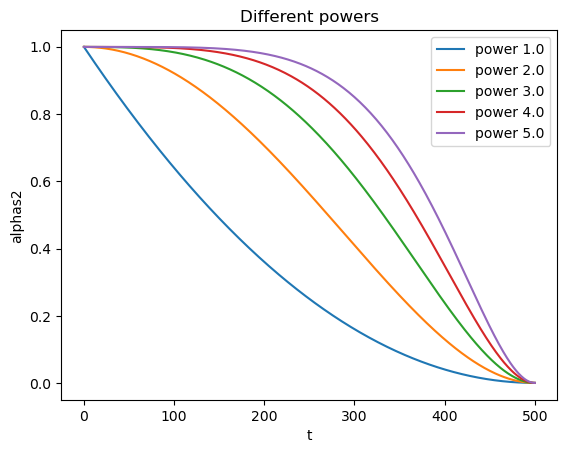

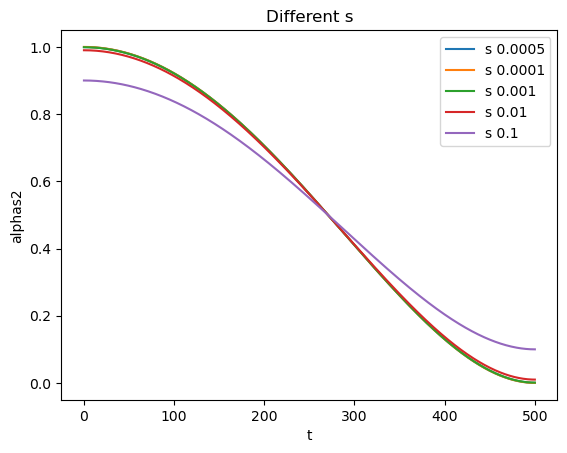

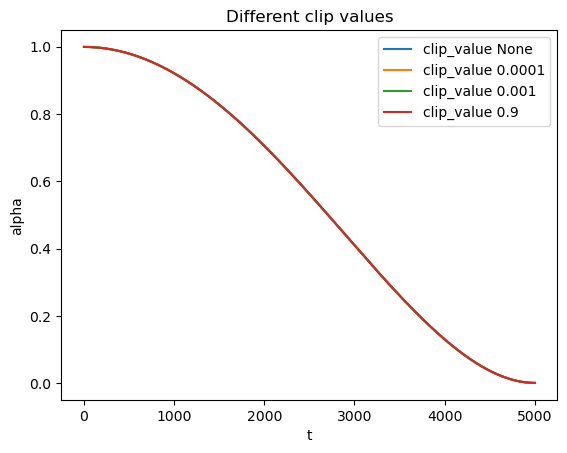

In [11]:
def clip_noise_schedule(alphas2, clip_value=0.001):
    """
    For a noise schedule given by alpha^2, this clips alpha_t / alpha_t-1.
    This may help improve stability during
    sampling.
    """
    alphas2 = np.concatenate([np.ones(1), alphas2], axis=0)


    alphas_step = (alphas2[1:] / alphas2[:-1])

    alphas_step = np.clip(alphas_step, a_min=clip_value, a_max=1.)
    alphas2 = np.cumprod(alphas_step, axis=0)


    return alphas2

def polynomial_schedule(timesteps: int, s=1e-4, power=3., clip_value=0.001):
    """
    A noise schedule based on a simple polynomial equation: 1 - x^power.
    """
    steps = timesteps + 1
    x = np.linspace(0, steps, steps)
    alphas2 = (1 - np.power(x / steps, power))**2

    if clip_value is not None:
        alphas2 = clip_noise_schedule(alphas2, clip_value=clip_value)

    precision = 1 - 2 * s

    alphas2 = precision * alphas2 + s

    return alphas2

for power in [1., 2., 3., 4., 5.]:
    plt.title(f"Different powers")
    alphas = polynomial_schedule(T, s=5.0e-4, power=power)
    plt.plot(alphas, label=f"power {power}")
    plt.xlabel("t")
    plt.ylabel("alphas2")
    plt.legend()

fig = plt.figure()
for _s in [5.0e-4, 1e-4, 1e-3, 1e-2, 1e-1]:
    plt.title(f"Different s")
    alphas = polynomial_schedule(T, s=_s, power=2.)
    plt.plot(alphas, label=f"s {_s}")
    plt.xlabel("t")
    plt.ylabel("alphas2")
    plt.legend()

fig = plt.figure()
for clip_value in [None, 0.0001, 0.001, 0.9]:
    plt.title(f"Different clip values")
    alphas = polynomial_schedule(5000, s=5.0e-4, power=2., clip_value=clip_value)
    plt.plot(alphas, label=f"clip_value {clip_value}")
    plt.xlabel("t")
    plt.ylabel("alpha")
    plt.legend()

    Analyze gamma

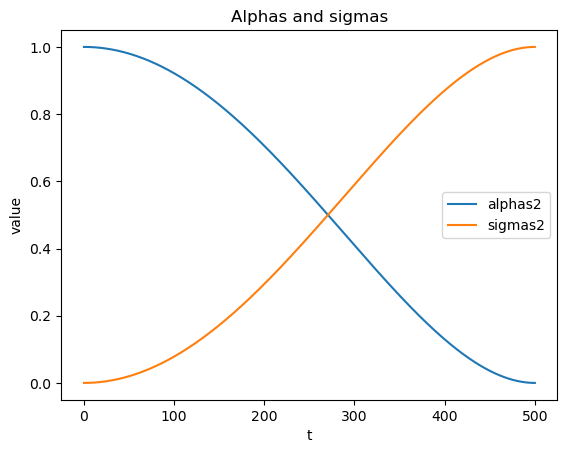

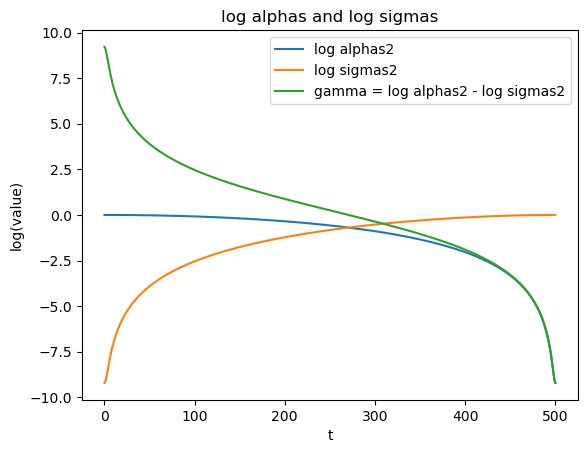

In [12]:
alphas2 = polynomial_schedule(T, s=1e-4, power=2.)
sigmas2 = 1 - alphas2
fig = plt.figure()
plt.title(f"Alphas and sigmas")
plt.plot(alphas2, label=f"alphas2")
plt.plot(sigmas2, label=f"sigmas2")
plt.xlabel("t")
plt.ylabel("value")
plt.legend()
log_alphas2 = np.log(alphas2)
log_sigmas2 = np.log(sigmas2)
fig = plt.figure()
plt.title(f"log alphas and log sigmas")
plt.plot(log_alphas2, label=f"log alphas2")
plt.plot(log_sigmas2, label=f"log sigmas2")
log_alphas2_to_sigmas2 = log_alphas2 - log_sigmas2
plt.plot(log_alphas2_to_sigmas2, label=f"gamma = log alphas2 - log sigmas2")
plt.xlabel("t")
plt.ylabel("log(value)")
plt.legend()


    Find gamma for each t and s

In [13]:
from equivariant_diffusion.en_diffusion import PredefinedNoiseSchedule
gamma = PredefinedNoiseSchedule("polynomial_2", timesteps=T, precision=5.0e-4)
### having shape = array.shape 
def inflate_batch_array(array, target):
        """
        Inflates the batch array (array) with only a single axis
        (i.e. shape = (batch_size,), or possibly more empty axes
        (i.e. shape (batch_size, 1, ..., 1)) to match the target shape.
        Having shape = array.shape -> reshape to target.shape with 1s
        """
        target_shape = (array.size(0),) + (1,) * (len(target.size()) - 1)
        return array.view(target_shape)

# Compute gamma_s and gamma_t via the network.
print(f"gamma(s) {gamma(s).shape}, gamma(t) {gamma(t).shape}")
gamma_s = inflate_batch_array(gamma(s), ligand['x'])
gamma_t = inflate_batch_array(gamma(t), ligand['x'])
print(f"gamma_s {gamma_s.shape}, gamma_t {gamma_t.shape}")
gamma_s, gamma_t

gamma(s) torch.Size([3, 1]), gamma(t) torch.Size([3, 1])
gamma_s torch.Size([3, 1]), gamma_t torch.Size([3, 1])


(tensor([[-1.0304],
         [ 4.3825],
         [-2.4166]]),
 tensor([[-1.0171],
         [ 4.4511],
         [-2.3959]]))

    Concatenate x, and h[categorical]

In [14]:
# Concatenate x, and h[categorical].
xh_lig = torch.cat([ligand_norm['x'], ligand_norm['one_hot']], dim=1)
xh_pocket = torch.cat([pocket_norm['x'], pocket_norm['one_hot']], dim=1)
print(f"ligand_norm['x'] {ligand_norm['x'].shape}, ligand_norm['one_hot'] {ligand_norm['one_hot'].shape}, xh_lig {xh_lig.shape}")
print(f"pocket_norm['x'] {pocket_norm['x'].shape}, pocket_norm['one_hot'] {pocket_norm['one_hot'].shape}, xh_pocket {xh_pocket.shape}")
xh_lig[:3], xh_pocket[:3]

ligand_norm['x'] torch.Size([76, 3]), ligand_norm['one_hot'] torch.Size([76, 10]), xh_lig torch.Size([76, 13])
pocket_norm['x'] torch.Size([132, 3]), pocket_norm['one_hot'] torch.Size([132, 20]), xh_pocket torch.Size([132, 23])


(tensor([[ -2.7050, -32.6100,   7.2150,   0.2500,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [ -1.9770, -31.8940,   8.3700,   0.2500,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [ -1.7200, -33.3450,   6.3130,   0.2500,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]]),
 tensor([[ -3.7220, -25.5020,   0.0470,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.2500,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000],
         [ -3.5170, -24.8470,   3.8010,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.2500,
            0.0000,   0.0000],
   

    Convert back from gamma to sigma and alpha

alpha_t torch.Size([3, 1]), sigma_t torch.Size([3, 1])


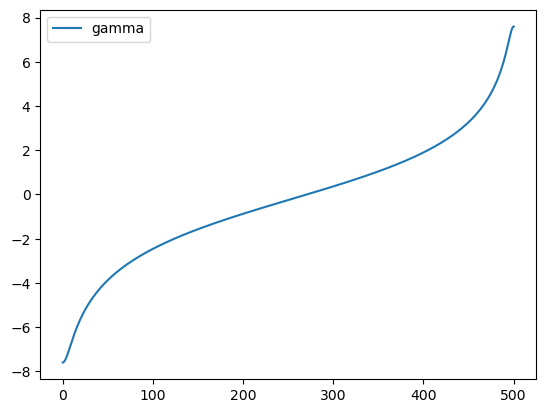

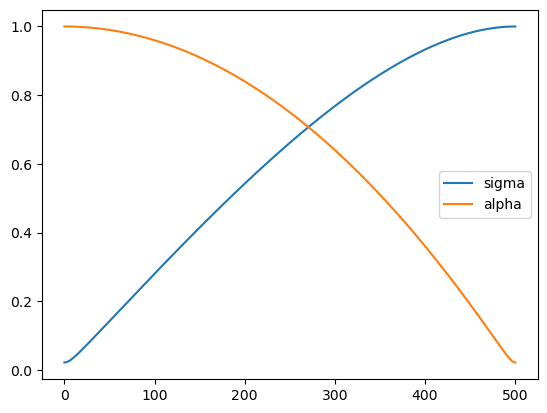

In [15]:
def sigma(gamma, target_tensor):
        """Computes sigma given gamma."""
        return inflate_batch_array(torch.sqrt(torch.sigmoid(gamma)),
                                        target_tensor)

def alpha(gamma, target_tensor):
    """Computes alpha given gamma."""
    return inflate_batch_array(torch.sqrt(torch.sigmoid(-gamma)),
                                    target_tensor)
alpha_t = alpha(gamma_t, xh_lig)  
sigma_t = sigma(gamma_t, xh_lig)
print (f"alpha_t {alpha_t.shape}, sigma_t {sigma_t.shape}")    
fig = plt.figure()
gamma_temp = gamma.gamma
plt.plot(gamma_temp, label=f"gamma")
plt.legend()
fig = plt.figure()
plt.plot(torch.sqrt(torch.sigmoid(gamma_temp)), label=f"sigma")
plt.plot(torch.sqrt(torch.sigmoid(-gamma_temp)), label=f"alpha")
plt.legend()

atom_nf 10, residue_nf 20
lig_indices torch.Size([76]), pocket_indices torch.Size([132])
size (208, 3)
random_x.shape torch.Size([208, 3])
indices.shape torch.Size([208])
mean.shape torch.Size([3, 3])
mean tensor([[ 0.1094, -0.0499,  0.1389],
        [-0.1592,  0.1074,  0.0457],
        [ 0.2228, -0.1900, -0.0332]])
mean[indices].shape torch.Size([208, 3])
z_x.shape torch.Size([208, 3])
z_h_lig.shape torch.Size([76, 10])
z_lig.shape torch.Size([76, 13])
z_h_pocket.shape torch.Size([132, 20])
z_pocket.shape torch.Size([132, 23])


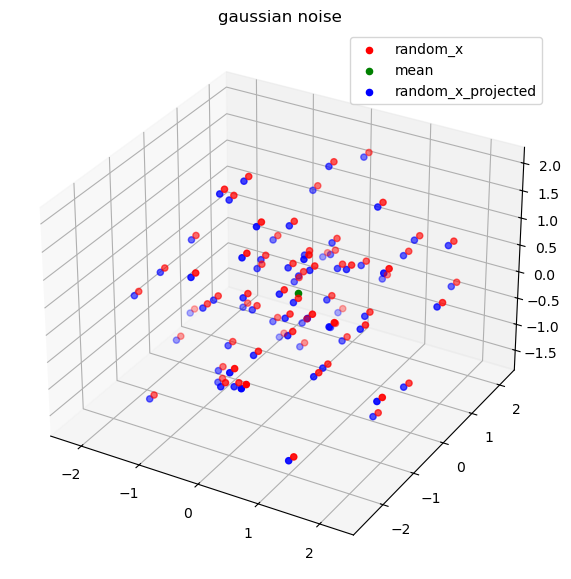

In [16]:
from torch_scatter import scatter_mean
from constants import dataset_params
dataset_info = dataset_params['crossdock']
atom_nf = len(dataset_info['atom_decoder'])
residue_nf = len(dataset_info['aa_decoder'])
print(f"atom_nf {atom_nf}, residue_nf {residue_nf}")
torch.manual_seed(42)

def remove_mean_batch(x, indices):
        mean = scatter_mean(x, indices, dim=0)
        x = x - mean[indices]
        return x

def sample_center_gravity_zero_gaussian_batch(size, lig_indices,
                                                  pocket_indices):
        assert len(size) == 2
        x = torch.randn(size, device=lig_indices.device)

        # This projection only works because Gaussian is rotation invariant
        # around zero and samples are independent!
        x_projected = remove_mean_batch(x, torch.cat((lig_indices, pocket_indices)))
        return x_projected

def sample_gaussian(size, device):
        x = torch.randn(size, device=device)
        return x

def sample_combined_position_feature_noise(lig_indices, pocket_indices):
        """
        Samples mean-centered normal noise for z_x, and standard normal noise
        for z_h.
        """
        z_x = sample_center_gravity_zero_gaussian_batch(
            size=(len(lig_indices) + len(pocket_indices), n_dims),
            lig_indices=lig_indices,
            pocket_indices=pocket_indices
        )
        z_h_lig = sample_gaussian(
            size=(len(lig_indices), atom_nf),
            device=lig_indices.device)
        z_lig = torch.cat([z_x[:len(lig_indices)], z_h_lig], dim=1)
        z_h_pocket = sample_gaussian(
            size=(len(pocket_indices), residue_nf),
            device=pocket_indices.device)
        z_pocket = torch.cat([z_x[len(lig_indices):], z_h_pocket], dim=1)
        return z_lig, z_pocket

lig_indices = ligand_norm['mask']
pocket_indices = pocket_norm['mask']
print(f"lig_indices {lig_indices.shape}, pocket_indices {pocket_indices.shape}")
size = (len(lig_indices) + len(pocket_indices), n_dims)
print(f"size {size}")
random_x = torch.randn(size, device=lig_indices.device)
print(f"random_x.shape {random_x.shape}")
indices = torch.cat((lig_indices, pocket_indices))
print(f"indices.shape {indices.shape}")
mean = scatter_mean(random_x, indices, dim=0)
print(f"mean.shape {mean.shape}") # mean.shape = (batch, n_dims)
print(f"mean {mean}")
print(f"mean[indices].shape {mean[indices].shape}") # mean[indices] - mean for each index in indices
z_x = random_x - mean[indices]
print(f"z_x.shape {z_x.shape}")
## plot 3d
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(random_x[indices==0][:,0], random_x[indices==0][:,1], random_x[indices==0][:,2], c='r', marker='o', label='random_x')
ax.scatter(mean[0][0], mean[0][1], mean[0][2], c='g', marker='o', label='mean')
ax.scatter(z_x[indices==0][:,0], z_x[indices==0][:,1], z_x[indices==0][:,2], c='b', marker='o', label='random_x_projected')
plt.legend()
plt.title(f"gaussian noise")
z_h_lig = sample_gaussian(size=(len(lig_indices), atom_nf),device=lig_indices.device)
print(f"z_h_lig.shape {z_h_lig.shape}")
z_lig = torch.cat([z_x[:len(lig_indices)], z_h_lig], dim=1)
print(f"z_lig.shape {z_lig.shape}")
z_h_pocket = sample_gaussian(size=(len(pocket_indices), residue_nf),device=pocket_indices.device)
print(f"z_h_pocket.shape {z_h_pocket.shape}")
z_pocket = torch.cat([z_x[len(lig_indices):], z_h_pocket], dim=1)
print(f"z_pocket.shape {z_pocket.shape}")



    Find noised representation

In [17]:
# Find noised representation
def noised_representation(xh_lig, xh_pocket, lig_mask, pocket_mask,
                              gamma_t):
        # Compute alpha_t and sigma_t from gamma.
        alpha_t = alpha(gamma_t, xh_lig)
        sigma_t = sigma(gamma_t, xh_lig)
        print(f"alpha_t {alpha_t.shape}, sigma_t {sigma_t.shape}")

        # Sample zt ~ Normal(alpha_t x, sigma_t)
        eps_lig, eps_pocket = sample_combined_position_feature_noise(
            lig_mask, pocket_mask)

        # Sample z_t given x, h for timestep t, from q(z_t | x, h)
        z_t_lig = alpha_t[lig_mask] * xh_lig + sigma_t[lig_mask] * eps_lig
        z_t_pocket = alpha_t[pocket_mask] * xh_pocket + \
                     sigma_t[pocket_mask] * eps_pocket

        return z_t_lig, z_t_pocket, eps_lig, eps_pocket

z_t_lig, z_t_pocket, eps_t_lig, eps_t_pocket = noised_representation(xh_lig, xh_pocket, ligand_norm['mask'], pocket_norm['mask'], gamma_t)
print(f"z_t_lig.shape {z_t_lig.shape}, z_t_pocket.shape {z_t_pocket.shape}, eps_t_lig.shape {eps_t_lig.shape}, eps_t_pocket.shape {eps_t_pocket.shape}")
print(f"z_t_lig[:3] {z_t_lig[:3]}, \nz_t_pocket[:3] {z_t_pocket[:3]}")

alpha_t torch.Size([3, 1]), sigma_t torch.Size([3, 1])
z_t_lig.shape torch.Size([76, 13]), z_t_pocket.shape torch.Size([132, 23]), eps_t_lig.shape torch.Size([76, 13]), eps_t_pocket.shape torch.Size([132, 23])
z_t_lig[:3] tensor([[-2.2148e+00, -2.8379e+01,  5.8287e+00,  4.0772e-01, -1.6987e-01,
         -8.7095e-01, -5.7670e-01,  4.4024e-01, -2.4411e-01, -1.6051e-03,
         -3.7757e-01, -6.4256e-01, -2.1099e-01],
        [-1.1853e+00, -2.6457e+01,  6.5366e+00,  3.3778e-01, -5.7603e-01,
         -4.8883e-02, -3.7577e-01,  4.0239e-01, -1.0169e+00,  3.8025e-01,
         -3.6276e-01,  1.8202e-01, -4.8193e-01],
        [-1.4278e+00, -2.8401e+01,  6.1826e+00,  1.7276e-01, -3.4063e-01,
         -5.5490e-01, -6.9159e-01,  2.1462e-01, -4.6696e-01,  2.6639e-01,
          3.4728e-01, -6.2843e-01,  1.8804e-02]]), 
z_t_pocket[:3] tensor([[-2.9664e+00, -2.1701e+01, -2.8210e-01,  1.0015e-01,  5.3718e-01,
         -5.8014e-01, -2.1045e-02,  3.6896e-01,  1.7615e-01, -3.4933e-01,
          9.1649e-02,

### Calculate dynamics

In [18]:
xh_atoms, xh_residues, t, mask_atoms, mask_residues = z_t_lig, z_t_pocket, t, ligand_norm['mask'], pocket_norm['mask']

In [19]:
n_dims = 3
x_atoms = xh_atoms[:, :n_dims].clone()
h_atoms = xh_atoms[:, n_dims:].clone()
print(f"x_atoms.shape {x_atoms.shape}, h_atoms.shape {h_atoms.shape}")
x_residues = xh_residues[:, :n_dims].clone()
h_residues = xh_residues[:, n_dims:].clone()
print(f"x_residues.shape {x_residues.shape}, h_residues.shape {h_residues.shape}")

x_atoms.shape torch.Size([76, 3]), h_atoms.shape torch.Size([76, 10])
x_residues.shape torch.Size([132, 3]), h_residues.shape torch.Size([132, 20])


    Embed atom features and residue features in a shared space

In [20]:
def forward_debug(x, layer):
    x_out = layer(x)
    print(f"x_out.shape {x_out.shape} after {layer}")
    return x_out


    Atom encoder

In [21]:
import torch.nn as nn
h_atoms = xh_atoms[:, n_dims:].clone()
atom_nf = len(dataset_info['atom_decoder'])
joint_nf = 128
act_fn = torch.nn.SiLU()
print (f"atom_nf {atom_nf}, joint_nf {joint_nf}")
atom_encoder = nn.Sequential(
            nn.Linear(atom_nf, 2 * atom_nf),
            act_fn,
            nn.Linear(2 * atom_nf, joint_nf)
        )
print(f"h_atoms.shape {h_atoms.shape}")
for layer in atom_encoder:
    h_atoms = forward_debug(h_atoms, layer)
print(f"h_atoms.shape {h_atoms.shape}")

atom_nf 10, joint_nf 128
h_atoms.shape torch.Size([76, 10])
x_out.shape torch.Size([76, 20]) after Linear(in_features=10, out_features=20, bias=True)
x_out.shape torch.Size([76, 20]) after SiLU()
x_out.shape torch.Size([76, 128]) after Linear(in_features=20, out_features=128, bias=True)
h_atoms.shape torch.Size([76, 128])


    Residue encoder

In [22]:
residue_nf = len(dataset_info['aa_decoder'])
print(f"residue_nf {residue_nf}, joint_nf {joint_nf}")
h_residues = xh_residues[:, n_dims:].clone()
residue_encoder = nn.Sequential(
            nn.Linear(residue_nf, 2 * residue_nf),
            act_fn,
            nn.Linear(2 * residue_nf, joint_nf)
        )
print(f"h_residues.shape {h_residues.shape}")
for layer in residue_encoder:
    h_residues = forward_debug(h_residues, layer)
print(f"h_residues.shape {h_residues.shape}")


residue_nf 20, joint_nf 128
h_residues.shape torch.Size([132, 20])
x_out.shape torch.Size([132, 40]) after Linear(in_features=20, out_features=40, bias=True)
x_out.shape torch.Size([132, 40]) after SiLU()
x_out.shape torch.Size([132, 128]) after Linear(in_features=40, out_features=128, bias=True)
h_residues.shape torch.Size([132, 128])


    combine the two node types

In [23]:
# combine the two node types
x = torch.cat((x_atoms, x_residues), dim=0)
x_egnn = x.clone()
h = torch.cat((h_atoms, h_residues), dim=0)
mask = torch.cat([mask_atoms, mask_residues])
print(f"x.shape {x.shape}, h.shape {h.shape}, mask.shape {mask.shape}")
print(mask)

x.shape torch.Size([208, 3]), h.shape torch.Size([208, 128]), mask.shape torch.Size([208])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


    Condition time is always true 

In [24]:
h_temp = h[mask==0]
print(f"h_temp.shape {h_temp.shape}")

h_temp.shape torch.Size([74, 128])


In [25]:
print(f"t {t}")
print(f"t.size() = {t.size()}")
print(f"np.prod(t.size()) = {np.prod(t.size())}")

t tensor([[0.3780],
        [0.9460],
        [0.2060]])
t.size() = torch.Size([3, 1])
np.prod(t.size()) = 3


In [26]:
print(f"If the batch size is 1")
t_temp = torch.Tensor([[10]])
print(f"t_temp.size() {t_temp.size()}")
h_temp = h[mask==0]
print(f"h_temp.shape {h_temp.shape}")
h_time_temp = torch.empty_like(h_temp[:, 0:1]).fill_(t_temp.item())
print(f"h_time_temp.shape {h_time_temp.shape}")
h_temp_out = torch.cat([h_temp, h_time_temp], dim=1)
print(f"h_temp_out.shape {h_temp_out.shape}")

If the batch size is 1
t_temp.size() torch.Size([1, 1])
h_temp.shape torch.Size([74, 128])
h_time_temp.shape torch.Size([74, 1])
h_temp_out.shape torch.Size([74, 129])


In [27]:
if np.prod(t.size()) == 1:
    # t is the same for all elements in batch. (Only 1 sample in batch)
    h_time = torch.empty_like(h[:, 0:1]).fill_(t.item())
else:
    # t is different over the batch dimension.
    h_time = t[mask]
    print(f"h_time.shape {h_time.shape}")
print(f"h.shape {h.shape}")
h = torch.cat([h, h_time], dim=1)
print(f"h.shape {h.shape}")

h_time.shape torch.Size([208, 1])
h.shape torch.Size([208, 128])
h.shape torch.Size([208, 129])


    get edges of a complete graph

mask_atoms.shape torch.Size([76]), mask_residues.shape torch.Size([132]), x_atoms.shape torch.Size([76, 3]), x_residues.shape torch.Size([132, 3])
adj_ligand.shape torch.Size([76, 76]), adj_pocket.shape torch.Size([132, 132]), adj_cross.shape torch.Size([76, 132])
torch.cat((adj_ligand, adj_cross), dim=1) torch.Size([76, 208])
torch.cat((adj_cross.T, adj_pocket), dim=1) torch.Size([132, 208])
adj.shape torch.Size([208, 208])
Number of edges: adj.sum() = 6798
len(torch.where(adj)) 2, torch.where(adj)[0].shape torch.Size([6798]), torch.where(adj)[1].shape torch.Size([6798])]
edges.shape torch.Size([2, 6798])
tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4]])


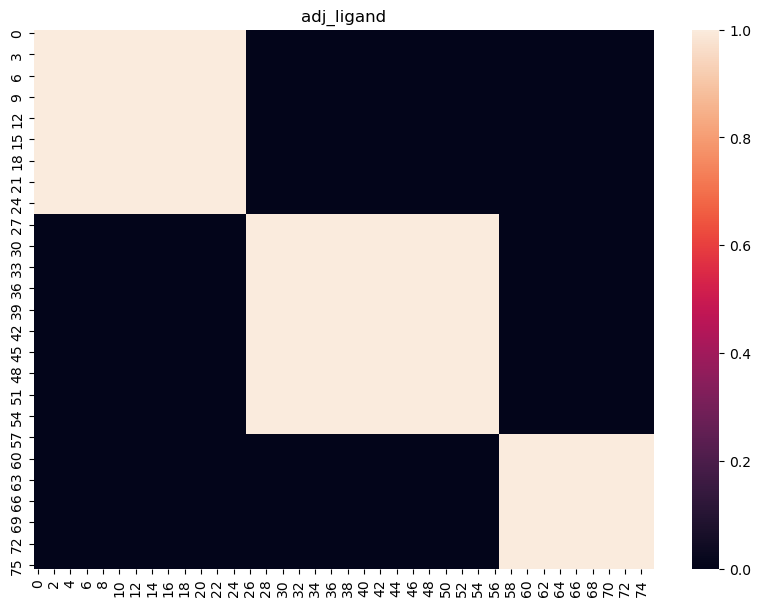

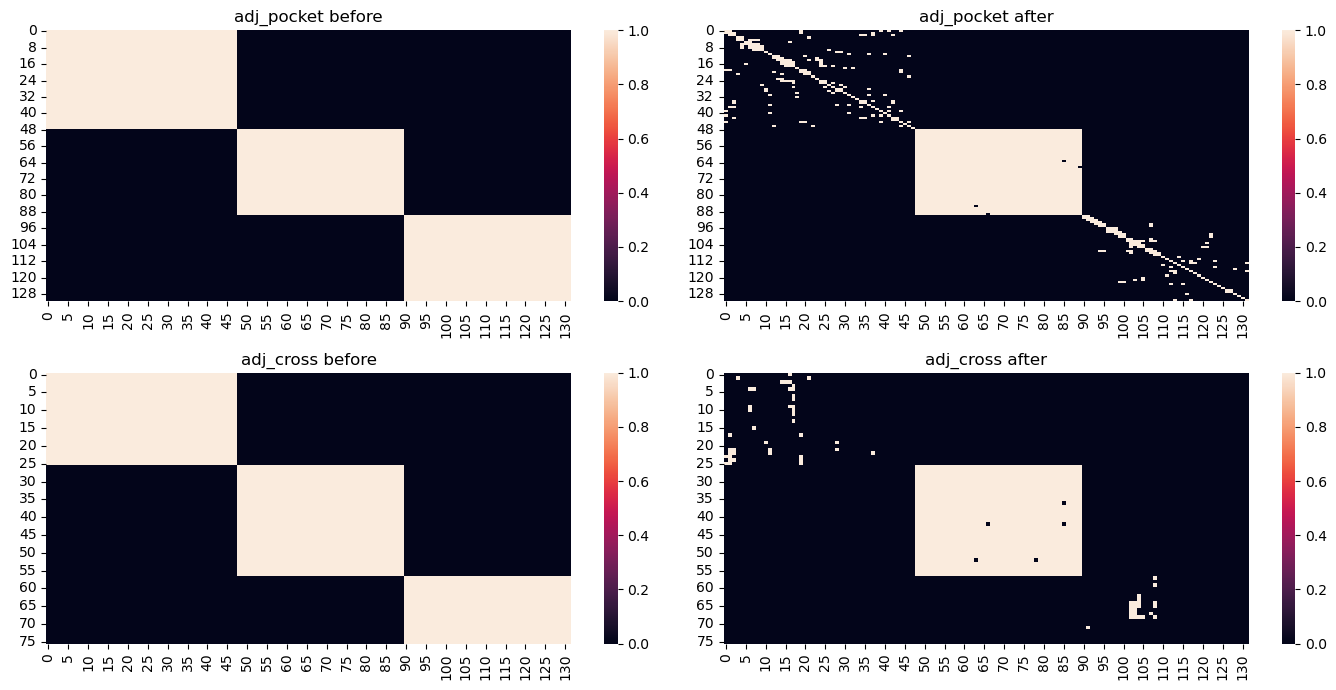

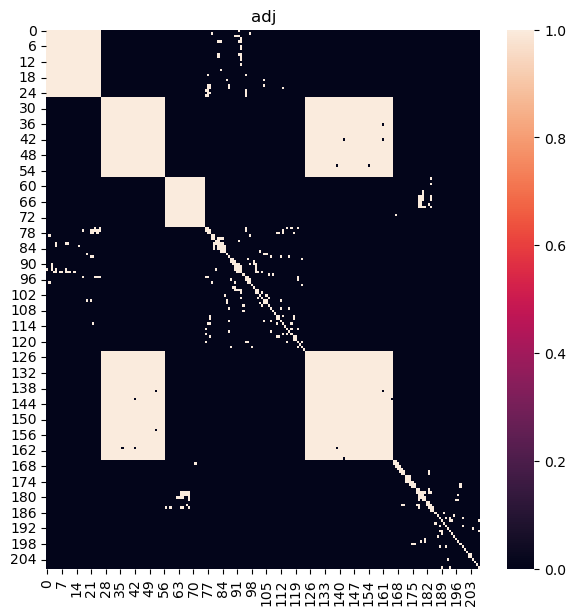

In [28]:
# get edges of a complete graph
import seaborn as sns
edge_cutoff_l = None #edge_cutoff_ligand
edge_cutoff_p = 5 #edge_cutoff_pocket
edge_cutoff_i = 5 #edge_cutoff_interaction


def get_edges(batch_mask_ligand, batch_mask_pocket, x_ligand, x_pocket):
        adj_ligand = batch_mask_ligand[:, None] == batch_mask_ligand[None, :]
        adj_pocket = batch_mask_pocket[:, None] == batch_mask_pocket[None, :]
        adj_cross = batch_mask_ligand[:, None] == batch_mask_pocket[None, :]
        ### columns and rows represent ligand and pocket nodes respectively. If cell is True, then these nodes are from the same batch. 
        print(f"adj_ligand.shape {adj_ligand.shape}, adj_pocket.shape {adj_pocket.shape}, adj_cross.shape {adj_cross.shape}")

        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111)
        sns.heatmap(adj_ligand, ax=ax)
        plt.title(f"adj_ligand")

        fig, axs = plt.subplots(2, 2, figsize=(14,7))
        sns.heatmap(adj_pocket, ax=axs[0, 0])
        axs[0, 0].set_title(f"adj_pocket before")

        # fig, axs_cross = plt.subplots(1, 2, figsize=(14,7))
        sns.heatmap(adj_cross, ax=axs[1, 0])
        axs[1, 0].set_title(f"adj_cross before")

        ### never used because edge_cutoff_l is always None
        if edge_cutoff_l is not None:
            adj_ligand = adj_ligand & (torch.cdist(x_ligand, x_ligand) <= edge_cutoff_l)

        ### torch.cdist returns pairwise distances between two atoms in a pocket.
        if edge_cutoff_p is not None:
            adj_pocket = adj_pocket & (torch.cdist(x_pocket, x_pocket) <= edge_cutoff_p)
        # plot heatmap of adj_pocket
        sns.heatmap(adj_pocket, ax=axs[0, 1])
        axs[0, 1].set_title(f"adj_pocket after")

        if edge_cutoff_i is not None:
            adj_cross = adj_cross & (torch.cdist(x_ligand, x_pocket) <= edge_cutoff_i)
        sns.heatmap(adj_cross, ax=axs[1, 1])
        axs[1, 1].set_title(f"adj_cross after")
        # show heatmap values
        for ax in axs.flat:
            ax.label_outer()
        
        plt.tight_layout()
        print(f"torch.cat((adj_ligand, adj_cross), dim=1) {torch.cat((adj_ligand, adj_cross), dim=1).shape}")
        print(f"torch.cat((adj_cross.T, adj_pocket), dim=1) {torch.cat((adj_cross.T, adj_pocket), dim=1).shape}")
        adj = torch.cat((torch.cat((adj_ligand, adj_cross), dim=1), # row := ligand, column := ligand and pocket, If cell is True -> connected
                         torch.cat((adj_cross.T, adj_pocket), dim=1)), dim=0) # row := pocket, column := ligand and pocket, If cell is True -> connected
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        sns.heatmap(adj, ax=ax)
        plt.title(f"adj")
        
        print(f"adj.shape {adj.shape}") # row := ligand and pocket, column := ligand and pocket, If cell is True -> connected
        print(f"Number of edges: adj.sum() = {adj.sum()}") # number of edges
        print(f"len(torch.where(adj)) {len(torch.where(adj))}, torch.where(adj)[0].shape {torch.where(adj)[0].shape}, torch.where(adj)[1].shape {torch.where(adj)[1].shape}]")
        edges = torch.stack(torch.where(adj), dim=0)
        return edges
print(f"mask_atoms.shape {mask_atoms.shape}, mask_residues.shape {mask_residues.shape}, x_atoms.shape {x_atoms.shape}, x_residues.shape {x_residues.shape}")
edges = get_edges(mask_atoms, mask_residues, x_atoms, x_residues)
print(f"edges.shape {edges.shape}")
print(edges[:, :5])

In [29]:
temp = torch.Tensor([True, False, True, False, True, True])
print(temp.shape)
out = temp[:, None] == temp[None, :]
print(out.shape)
print(out)

torch.Size([6])
torch.Size([6, 6])
tensor([[ True, False,  True, False,  True,  True],
        [False,  True, False,  True, False, False],
        [ True, False,  True, False,  True,  True],
        [False,  True, False,  True, False, False],
        [ True, False,  True, False,  True,  True],
        [ True, False,  True, False,  True,  True]])


In [30]:
edge_types = None # Since there are no edge embeddings

    EGNN CLASS DYNAMICS

In [31]:
update_pocket_coords = True
update_coords_mask = None if update_pocket_coords \
                else torch.cat((torch.ones_like(mask_atoms),
                                torch.zeros_like(mask_residues))).unsqueeze(1)
update_coords_mask

In [32]:
h = h
x = x
edge_index = edges
update_coords_mask=update_coords_mask
batch_mask=mask
edge_attr=edge_types
print(f"h.shape {h.shape}, x.shape {x.shape}, edge_index.shape {edge_index.shape}, update_coords_mask {update_coords_mask}, batch_mask.shape {batch_mask.shape}, edge_attr {edge_attr}")

h.shape torch.Size([208, 129]), x.shape torch.Size([208, 3]), edge_index.shape torch.Size([2, 6798]), update_coords_mask None, batch_mask.shape torch.Size([208]), edge_attr None


In [33]:
def coord2diff(x, edge_index, norm_constant=1):
    row, col = edge_index
    print(f"row.shape {row.shape}, col.shape {col.shape}")
    print(f"x.shape {x.shape}")
    coord_diff = x[row] - x[col]
    print(f"coord_diff.shape {coord_diff.shape}")
    radial = torch.sum((coord_diff) ** 2, 1).unsqueeze(1) # distance squared between two atoms having an edge 
    print(f"radial.shape {radial.shape}")
    norm = torch.sqrt(radial + 1e-8)
    coord_diff = coord_diff/(norm + norm_constant)
    return radial, coord_diff

edge_feat, _ = coord2diff(x, edge_index)
print(f"edge_feat.shape {edge_feat.shape}")

row.shape torch.Size([6798]), col.shape torch.Size([6798])
x.shape torch.Size([208, 3])
coord_diff.shape torch.Size([6798, 3])
radial.shape torch.Size([6798, 1])
edge_feat.shape torch.Size([6798, 1])


In [34]:
x_temp = torch.Tensor([[1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
print(f"x_temp.shape {x_temp.shape}")
print(f"x_temp: \n {x_temp}")
row_temp = torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0, 1]).long()
print(f"row_temp.shape {row_temp.shape}")
out = x_temp[row_temp]
print(f"out.shape {out.shape}")
print(f"out: \n {out}")

x_temp.shape torch.Size([4, 3])
x_temp: 
 tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.]])
row_temp.shape torch.Size([9])
out.shape torch.Size([9, 3])
out: 
 tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [2., 2., 2.]])


In [35]:
dynamics_node_nf = joint_nf + 1
in_node_nf=dynamics_node_nf
hidden_nf=256
print(f"in_node_nf {in_node_nf}, hidden_nf {hidden_nf}")

embedding = nn.Linear(in_node_nf, hidden_nf)
print(f"h.shape {h.shape}")
h = embedding(h)
print(f"h.shape {h.shape}")

in_node_nf 129, hidden_nf 256
h.shape torch.Size([208, 129])
h.shape torch.Size([208, 256])


    EquivariantBlock

In [36]:
h, x, edge_index = h, x, edge_index
node_mask = None
edge_mask = None
edge_attr = edge_feat
update_coords_mask = update_coords_mask
batch_mask = batch_mask
arrs = [h, x, edge_index, node_mask, edge_mask, edge_attr, update_coords_mask, batch_mask]
names = ["h", "x", "edge_index", "node_mask", "edge_mask", "edge_attr", "update_coords_mask", "batch_mask"]
for arrs, name in zip(arrs, names):
    if arrs is not None:
        print(f"{name} {arrs.shape}")
    else:
        print(f"{name} {arrs}")
        


h torch.Size([208, 256])
x torch.Size([208, 3])
edge_index torch.Size([2, 6798])
node_mask None
edge_mask None
edge_attr torch.Size([6798, 1])
update_coords_mask None
batch_mask torch.Size([208])


In [37]:
norm_constant=1
distances, coord_diff = coord2diff(x, edge_index, norm_constant)
print(f"distances.shape {distances.shape}, coord_diff.shape {coord_diff.shape}")

row.shape torch.Size([6798]), col.shape torch.Size([6798])
x.shape torch.Size([208, 3])
coord_diff.shape torch.Size([6798, 3])
radial.shape torch.Size([6798, 1])
distances.shape torch.Size([6798, 1]), coord_diff.shape torch.Size([6798, 3])


In [38]:
def unsorted_segment_sum(data, segment_ids, num_segments, normalization_factor, aggregation_method: str):
    """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
        Normalization: 'sum' or 'mean'.
    """
    print(f"num_segments {num_segments}")
    result_shape = (num_segments, data.size(1))
    print(f"result_shape {result_shape}")
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    print(f"segment_ids.shape before {segment_ids.shape}")
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    print(f"segment_ids.shape after {segment_ids.shape}")
    print(f"results before {result}")
    result.scatter_add_(0, segment_ids, data) # row := batch id, column := x, y, z, value := sum
    print(f"result after {result}")
    if aggregation_method == 'sum':
        result = result / normalization_factor

    if aggregation_method == 'mean':
        norm = data.new_zeros(result.shape)
        norm.scatter_add_(0, segment_ids, data.new_ones(data.shape))
        norm[norm == 0] = 1
        result = result / norm
    return result


def coord2cross(x, edge_index, batch_mask, norm_constant=1):
    mean = unsorted_segment_sum(x, batch_mask,
                                num_segments=batch_mask.max() + 1,
                                normalization_factor=None,
                                aggregation_method='mean')
    row, col = edge_index
    cross = torch.cross(x[row]-mean[batch_mask[row]],
                        x[col]-mean[batch_mask[col]], dim=1)
    print(f"cross.shape {cross.shape}")
    norm = torch.linalg.norm(cross, dim=1, keepdim=True)
    cross = cross / (norm + norm_constant)
    return cross

print(f"x.shape {x.shape}, edge_index.shape {edge_index.shape}, batch_mask.shape {batch_mask.shape}")
coord_cross = coord2cross(x, edge_index, batch_mask, norm_constant)
print(f"coord_cross.shape {coord_cross.shape}")


x.shape torch.Size([208, 3]), edge_index.shape torch.Size([2, 6798]), batch_mask.shape torch.Size([208])
num_segments 3
result_shape (tensor(3), 3)
segment_ids.shape before torch.Size([208])
segment_ids.shape after torch.Size([208, 3])
results before tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
result after tensor([[ -252.5723, -1968.1379,   361.5182],
        [ -109.7575,   143.8257,    63.7121],
        [  996.9017,   563.6884,   616.8564]])
cross.shape torch.Size([6798, 3])
coord_cross.shape torch.Size([6798, 3])


In [39]:
zeros = torch.zeros((3,3))
print(f"zeros.shape {zeros.shape}")
src = torch.Tensor([[0,0,1], [1,1,2], [2,2,3], [0, 0, 1], [3, 3, 4], [1, 1, 2]])
indices = torch.Tensor([0, 1, 2, 0, 0, 1]).long()
indices = indices.unsqueeze(-1).expand(-1, 3)
zeros = zeros.scatter_add_(0, indices, src)
print(f"zeros {zeros}")

zeros.shape torch.Size([3, 3])
zeros tensor([[3., 3., 6.],
        [2., 2., 4.],
        [2., 2., 3.]])


In [40]:
print(f"distances {distances.shape}, edge_attr {edge_attr.shape}")
edge_attr = torch.cat([distances, edge_attr], dim=1)
print(f"edge_attr {edge_attr.shape}")
edge_attr

distances torch.Size([6798, 1]), edge_attr torch.Size([6798, 1])
edge_attr torch.Size([6798, 2])


tensor([[ 0.0000,  0.0000],
        [ 5.2577,  5.2577],
        [ 0.7452,  0.7452],
        ...,
        [17.7192, 17.7192],
        [20.3265, 20.3265],
        [ 0.0000,  0.0000]])

    GCL

In [41]:
h, edge_index = h, edge_index
edge_attr=edge_attr
node_mask=node_mask
edge_mask=edge_mask
node_attr=None
arr = [h, edge_index, edge_attr, node_mask, edge_mask, node_attr]
names = ["h", "edge_index", "edge_attr", "node_mask", "edge_mask", "node_attr"]
for arr, name in zip(arr, names):
    if arr is not None:
        print(f"{name} {arr.shape}")
    else:
        print(f"{name} {arr}")

h torch.Size([208, 256])
edge_index torch.Size([2, 6798])
edge_attr torch.Size([6798, 2])
node_mask None
edge_mask None
node_attr None


In [42]:
row, col = edge_index
print(f"row.shape {row.shape}, col.shape {col.shape}")

row.shape torch.Size([6798]), col.shape torch.Size([6798])


In [43]:
input_nf = hidden_nf
input_edge = input_nf * 2

edge_feat_nf = 2
edge_embedding_dim = None
edge_nf = 0
in_edge_nf = 0
edge_feat_nf = edge_feat_nf + in_edge_nf
edges_in_d=edge_feat_nf

attention=True

print(f"input_edge {input_edge}, edges_in_d {edges_in_d}, edges_in_d {edges_in_d}, hidden_nf {hidden_nf}")

edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

att_mlp = nn.Sequential(nn.Linear(hidden_nf, 1),nn.Sigmoid())

def edge_model(source, target, edge_attr, edge_mask):
    print(f"source.shape {source.shape}, target.shape {target.shape}, edge_attr.shape {edge_attr.shape}, edge_mask {edge_mask}")

    if edge_attr is None:  # Unused.
        out = torch.cat([source, target], dim=1)
    else:
        out = torch.cat([source, target, edge_attr], dim=1)
    print(f"out.shape {out.shape}")
    mij = out
    for layer in edge_mlp:
        mij = forward_debug(mij, layer)
    print(f"mij.shape {mij.shape}")

    if attention: # always True
        #att_val = att_mlp(mij)
        
        att_val = mij 
        for layer in att_mlp:
            att_val = forward_debug(att_val, layer)
        print(f"att_val.shape {att_val.shape}")
        out = mij * att_val
        print(f"out.shape {out.shape}")
    else:
        out = mij

    if edge_mask is not None: # is None
        out = out * edge_mask
    return out, mij
edge_feat, mij = edge_model(h[row], h[col], edge_attr, edge_mask)
print(f"edge_feat.shape {edge_feat.shape}, mij.shape {mij.shape}")

input_edge 512, edges_in_d 2, edges_in_d 2, hidden_nf 256
source.shape torch.Size([6798, 256]), target.shape torch.Size([6798, 256]), edge_attr.shape torch.Size([6798, 2]), edge_mask None
out.shape torch.Size([6798, 514])
x_out.shape torch.Size([6798, 256]) after Linear(in_features=514, out_features=256, bias=True)
x_out.shape torch.Size([6798, 256]) after SiLU()
x_out.shape torch.Size([6798, 256]) after Linear(in_features=256, out_features=256, bias=True)
x_out.shape torch.Size([6798, 256]) after SiLU()
mij.shape torch.Size([6798, 256])
x_out.shape torch.Size([6798, 1]) after Linear(in_features=256, out_features=1, bias=True)
x_out.shape torch.Size([6798, 1]) after Sigmoid()
att_val.shape torch.Size([6798, 1])
out.shape torch.Size([6798, 256])
edge_feat.shape torch.Size([6798, 256]), mij.shape torch.Size([6798, 256])


In [44]:
normalization_factor = 100
aggregation_method = "sum"
hidden_nf = 256
input_nf = hidden_nf
nodes_att_dim = 0
output_nf = hidden_nf

node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

def unsorted_segment_sum(data, segment_ids, num_segments, normalization_factor, aggregation_method: str):
    """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
        Normalization: 'sum' or 'mean'.
    """
    print(f"num_segments {num_segments}")
    result_shape = (num_segments, data.size(1))
    print(f"result_shape {result_shape}")
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    print(f"segment_ids.shape before {segment_ids.shape}")
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    print(f"segment_ids.shape after {segment_ids.shape}")
    print(f"results before {result.shape}")
    result.scatter_add_(0, segment_ids, data) # row := atom idx , column := edge_features, value := sum
    print(f"result after {result.shape}")
    if aggregation_method == 'sum':
        result = result / normalization_factor

    if aggregation_method == 'mean':
        norm = data.new_zeros(result.shape)
        norm.scatter_add_(0, segment_ids, data.new_ones(data.shape))
        norm[norm == 0] = 1
        result = result / norm
    return result

def node_model(x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        print(f"row.shape {row.shape}, col.shape {col.shape}")
        ### sum all edge features for each atom
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0),
                                   normalization_factor=normalization_factor,
                                   aggregation_method=aggregation_method)
        print(f"agg.shape {agg.shape}")
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        print(f"agg.shape {agg.shape}")
        node_mlp_out = agg
        for layer in node_mlp:
            node_mlp_out = forward_debug(node_mlp_out, layer)
        print(f"node_mlp_out.shape {node_mlp_out.shape}")
        out = x + node_mlp_out
        print(f"out.shape {out.shape}")
        return out, agg


print(f"h.shape {h.shape}, edge_index.shape {edge_index.shape}, edge_feat.shape {edge_feat.shape}, node_attr {node_attr}")
h, agg = node_model(h, edge_index, edge_feat, node_attr)
print(f"h.shape {h.shape}, agg.shape {agg.shape}")

h.shape torch.Size([208, 256]), edge_index.shape torch.Size([2, 6798]), edge_feat.shape torch.Size([6798, 256]), node_attr None
row.shape torch.Size([6798]), col.shape torch.Size([6798])
num_segments 208
result_shape (208, 256)
segment_ids.shape before torch.Size([6798])
segment_ids.shape after torch.Size([6798, 256])
results before torch.Size([208, 256])
result after torch.Size([208, 256])
agg.shape torch.Size([208, 256])
agg.shape torch.Size([208, 512])
x_out.shape torch.Size([208, 256]) after Linear(in_features=512, out_features=256, bias=True)
x_out.shape torch.Size([208, 256]) after SiLU()
x_out.shape torch.Size([208, 256]) after Linear(in_features=256, out_features=256, bias=True)
node_mlp_out.shape torch.Size([208, 256])
out.shape torch.Size([208, 256])
h.shape torch.Size([208, 256]), agg.shape torch.Size([208, 512])


    EquivariantUpdate

In [45]:
hidden_nf = hidden_nf
edges_in_d = edge_feat_nf
act_fn = nn.SiLU()
tanh = True
coords_range = 15
normalization_factor = normalization_factor
aggregation_method = aggregation_method
reflection_equiv = False

arr = [hidden_nf, edges_in_d, act_fn, tanh, coords_range, normalization_factor, aggregation_method, reflection_equiv]
names = ["hidden_nf", "edges_in_d", "act_fn", "tanh", "coords_range", "normalization_factor", "aggregation_method", "reflection_equiv"]
for arr, name in zip(arr, names):
    if arr is not None:
        print(f"{name} {arr}")
    else:
        print(f"{name} {arr}")



hidden_nf 256
edges_in_d 2
act_fn SiLU()
tanh True
coords_range 15
normalization_factor 100
aggregation_method sum
reflection_equiv False


In [46]:
h = h
coord = x
edge_index = edge_index
coord_diff = coord_diff 
coord_cross = coord_cross
edge_attr=edge_attr 
node_mask=node_mask
edge_mask=edge_mask
update_coords_mask=update_coords_mask

arr = [h, coord, edge_index, coord_diff, coord_cross, edge_attr, node_mask, edge_mask, update_coords_mask]
names = ["h", "coord", "edge_index", "coord_diff", "coord_cross", "edge_attr", "node_mask", "edge_mask", "update_coords_mask"]
for arr, name in zip(arr, names):
    if arr is not None:
        print(f"{name} {arr.shape}")
    else:
        print(f"{name} {arr}")


h torch.Size([208, 256])
coord torch.Size([208, 3])
edge_index torch.Size([2, 6798])
coord_diff torch.Size([6798, 3])
coord_cross torch.Size([6798, 3])
edge_attr torch.Size([6798, 2])
node_mask None
edge_mask None
update_coords_mask None


In [47]:
input_edge = hidden_nf * 2 + edges_in_d
layer = nn.Linear(hidden_nf, 1, bias=False)
coord_mlp = nn.Sequential(
            nn.Linear(input_edge, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn,
            layer)

cross_product_mlp = nn.Sequential(
            nn.Linear(input_edge, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn,
            layer)

def unsorted_segment_sum(data, segment_ids, num_segments, normalization_factor, aggregation_method: str):
    """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
        Normalization: 'sum' or 'mean'.
    """
    print("IN UNSORTED SEGMENT SUM")
    print(f"num_segments {num_segments}")
    result_shape = (num_segments, data.size(1))
    print(f"result_shape {result_shape}")
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    print(f"segment_ids.shape before {segment_ids.shape}")
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    print(f"segment_ids.shape after {segment_ids.shape}")
    print(f"results before {result.shape}")
    result.scatter_add_(0, segment_ids, data) # row := atom idx , column := x,y,z, value := sum
    print(f"result after {result.shape}")
    if aggregation_method == 'sum':
        result = result / normalization_factor

    if aggregation_method == 'mean':
        norm = data.new_zeros(result.shape)
        norm.scatter_add_(0, segment_ids, data.new_ones(data.shape))
        norm[norm == 0] = 1
        result = result / norm
    print("END UNSORTED SEGMENT SUM")
    return result

def coord_model(h, coord, edge_index, coord_diff, coord_cross,
                    edge_attr, edge_mask, update_coords_mask=None):
    row, col = edge_index
    print(f"row.shape {row.shape}, col.shape {col.shape}")
    input_tensor = torch.cat([h[row], h[col], edge_attr], dim=1)
    print(f"input_tensor.shape {input_tensor.shape}")
    ## Always True
    if tanh:
        coord_mlp_out = input_tensor
        for layer in coord_mlp:
            coord_mlp_out = forward_debug(coord_mlp_out, layer)
        print(f"coord_mlp_out.shape {coord_mlp_out.shape}")
        print(f"coord_diff.shape {coord_diff.shape}, coords_range {coords_range}")
        trans = coord_diff * torch.tanh(coord_mlp_out) * coords_range
    else:
        trans = coord_diff * coord_mlp(input_tensor)

    if not reflection_equiv: # always True
        print(f"input_tensor.shape {input_tensor.shape}")
        phi_cross = input_tensor
        for layer in cross_product_mlp:
            phi_cross = forward_debug(phi_cross, layer)
        if tanh:
            phi_cross = torch.tanh(phi_cross) * coords_range
        print(f"phi_cross.shape {phi_cross.shape}")
        print(f"trans.shape {trans.shape}")
        trans = trans + coord_cross * phi_cross
        print(f"trans.shape {trans.shape}")

    if edge_mask is not None: # edge_mask is always None
        trans = trans * edge_mask

    agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0),
                                normalization_factor=normalization_factor,
                                aggregation_method=aggregation_method)
    print(f"agg.shape {agg.shape}")

    if update_coords_mask is not None: # update_coords_mask is always None
        agg = update_coords_mask * agg

    coord = coord + agg
    return coord

coord = coord_model(h, coord, edge_index, coord_diff, coord_cross,
                                 edge_attr, edge_mask,
                                 update_coords_mask=update_coords_mask)
print(f"coord.shape {coord.shape}")

row.shape torch.Size([6798]), col.shape torch.Size([6798])
input_tensor.shape torch.Size([6798, 514])
x_out.shape torch.Size([6798, 256]) after Linear(in_features=514, out_features=256, bias=True)
x_out.shape torch.Size([6798, 256]) after SiLU()
x_out.shape torch.Size([6798, 256]) after Linear(in_features=256, out_features=256, bias=True)
x_out.shape torch.Size([6798, 256]) after SiLU()
x_out.shape torch.Size([6798, 1]) after Linear(in_features=256, out_features=1, bias=False)
coord_mlp_out.shape torch.Size([6798, 1])
coord_diff.shape torch.Size([6798, 3]), coords_range 15
input_tensor.shape torch.Size([6798, 514])
x_out.shape torch.Size([6798, 256]) after Linear(in_features=514, out_features=256, bias=True)
x_out.shape torch.Size([6798, 256]) after SiLU()
x_out.shape torch.Size([6798, 256]) after Linear(in_features=256, out_features=256, bias=True)
x_out.shape torch.Size([6798, 256]) after SiLU()
x_out.shape torch.Size([6798, 1]) after Linear(in_features=256, out_features=1, bias=Fals

    Come back to EGNN

In [48]:
in_node_nf = joint_nf + 1
out_node_nf = in_node_nf
print(f"out_node_nf {out_node_nf}")
print(f"hidden_nf {hidden_nf}")

embedding_out = nn.Linear(hidden_nf, out_node_nf)

out_node_nf 129
hidden_nf 256


In [49]:
print(f"h.shape {h.shape}")
h = forward_debug(h, embedding_out)
print(f"h.shape {h.shape}")

h.shape torch.Size([208, 256])
x_out.shape torch.Size([208, 129]) after Linear(in_features=256, out_features=129, bias=True)
h.shape torch.Size([208, 129])


In [50]:
x_final = x
h_final = h
print(f"x_final.shape {x_final.shape}, h_final.shape {h_final.shape}")

x_final.shape torch.Size([208, 3]), h_final.shape torch.Size([208, 129])


In [51]:
vel = (x_final - x_egnn)
h_final = h_final[:, :-1]
print(f"vel.shape {vel.shape}, h_final.shape {h_final.shape}")

vel.shape torch.Size([208, 3]), h_final.shape torch.Size([208, 128])


In [52]:
# decode atom and residue features
joint_nf = 128
print(f"joint_nf {joint_nf}, atom_nf {atom_nf}, residue_nf {residue_nf}")

atom_decoder = nn.Sequential(
    nn.Linear(joint_nf, 2 * atom_nf),
    act_fn,
    nn.Linear(2 * atom_nf, atom_nf)
)

residue_decoder = nn.Sequential(
    nn.Linear(joint_nf, 2 * residue_nf),
    act_fn,
    nn.Linear(2 * residue_nf, residue_nf)
)


print(f"len(mask_atoms) {len(mask_atoms)}, len(mask_residues) {len(mask_residues)}")

h_final_atoms = h_final[:len(mask_atoms)] 
for layer in atom_decoder:
    h_final_atoms = forward_debug(h_final_atoms, layer)
print(f"h_final_atoms.shape {h_final_atoms.shape}")

h_final_residues = h_final[len(mask_atoms):]
for layer in residue_decoder:
    h_final_residues = forward_debug(h_final_residues, layer)
print(f"h_final_residues.shape {h_final_residues.shape}")

joint_nf 128, atom_nf 10, residue_nf 20
len(mask_atoms) 76, len(mask_residues) 132
x_out.shape torch.Size([76, 20]) after Linear(in_features=128, out_features=20, bias=True)
x_out.shape torch.Size([76, 20]) after SiLU()
x_out.shape torch.Size([76, 10]) after Linear(in_features=20, out_features=10, bias=True)
h_final_atoms.shape torch.Size([76, 10])
x_out.shape torch.Size([132, 40]) after Linear(in_features=128, out_features=40, bias=True)
x_out.shape torch.Size([132, 40]) after SiLU()
x_out.shape torch.Size([132, 20]) after Linear(in_features=40, out_features=20, bias=True)
h_final_residues.shape torch.Size([132, 20])


In [53]:
if torch.any(torch.isnan(vel)):
    print("vel has NaNs")
else:
    print("vel has no NaNs")
print(f"update_pocket_coords {update_pocket_coords}")

vel has no NaNs
update_pocket_coords True


In [54]:
def remove_mean_batch(x, indices):
    print(f"x.shape {x.shape}, indices.shape {indices.shape}")
    mean = scatter_mean(x, indices, dim=0)
    print(f"mean.shape {mean.shape}")
    x = x - mean[indices]
    return x

vel_temp = remove_mean_batch(vel, mask)
print(f"vel_temp.shape {vel_temp.shape}")

x.shape torch.Size([208, 3]), indices.shape torch.Size([208])
mean.shape torch.Size([3, 3])
vel_temp.shape torch.Size([208, 3])


In [55]:
vel = vel_temp

In [56]:
net_out_lig = torch.cat([vel[:len(mask_atoms)], h_final_atoms], dim=-1)
net_out_pocket = torch.cat([vel[len(mask_atoms):], h_final_residues], dim=-1)
print(f"net_out_lig.shape {net_out_lig.shape}, net_out_pocket.shape {net_out_pocket.shape}")

net_out_lig.shape torch.Size([76, 13]), net_out_pocket.shape torch.Size([132, 23])


In [57]:
def xh_given_zt_and_epsilon(z_t, epsilon, gamma_t, batch_mask):
        """ Equation (7) in the EDM paper """
        alpha_t = alpha(gamma_t, z_t)
        sigma_t = sigma(gamma_t, z_t)
        xh = z_t / alpha_t[batch_mask] - epsilon * sigma_t[batch_mask] / \
             alpha_t[batch_mask]
        return xh

print(f"zt_lig.shape {z_t_lig.shape}, net_out_lig.shape {net_out_lig.shape}, gamma_t.shape {gamma_t.shape}, ligand['mask'].shape {ligand['mask'].shape}")
xh_lig_hat = xh_given_zt_and_epsilon(z_t_lig, net_out_lig, gamma_t, ligand['mask'])
print(f"xh_lig_hat.shape {xh_lig_hat.shape}")

zt_lig.shape torch.Size([76, 13]), net_out_lig.shape torch.Size([76, 13]), gamma_t.shape torch.Size([3, 1]), ligand['mask'].shape torch.Size([76])
xh_lig_hat.shape torch.Size([76, 13])


In [58]:
from torch_scatter import scatter_add

def sum_except_batch(x, indices):
    return scatter_add(x.sum(-1), indices, dim=0)

print(f"eps_t_lig.shape {eps_t_lig.shape}, net_out_lig.shape {net_out_lig.shape}, ligand['mask'].shape {ligand['mask'].shape}")
error_t_lig = sum_except_batch((eps_t_lig - net_out_lig) ** 2, ligand['mask'])
print(f"error_t_lig.shape {error_t_lig.shape}")

eps_t_lig.shape torch.Size([76, 13]), net_out_lig.shape torch.Size([76, 13]), ligand['mask'].shape torch.Size([76])
error_t_lig.shape torch.Size([3])


In [59]:
print(f"eps_t_pocket.shape {eps_t_pocket.shape}, net_out_pocket.shape {net_out_pocket.shape}, pocket['mask'].shape {pocket['mask'].shape}")
error_t_pocket = sum_except_batch((eps_t_pocket - net_out_pocket) ** 2, pocket['mask'])
print(f"error_t_pocket.shape {error_t_pocket.shape}")

eps_t_pocket.shape torch.Size([132, 23]), net_out_pocket.shape torch.Size([132, 23]), pocket['mask'].shape torch.Size([132])
error_t_pocket.shape torch.Size([3])


    Compute weighting with SNR: (1 - SNR(s-t)) for epsilon parametrization

In [60]:
def SNR(gamma):
        """Computes signal to noise ratio (alpha^2/sigma^2) given gamma."""
        return torch.exp(-gamma)
print(f"gamma_s.shape {gamma_s.shape}, gamma_t.shape {gamma_t.shape}")

SNR_weight = (1 - SNR(gamma_s - gamma_t)).squeeze(1)
print(f"SNR_weight.shape {SNR_weight.shape}")
assert error_t_lig.size() == SNR_weight.size()
print(f"error_t_lig.size() {error_t_lig.size()}, SNR_weight.size() {SNR_weight.size()}")

gamma_s.shape torch.Size([3, 1]), gamma_t.shape torch.Size([3, 1])
SNR_weight.shape torch.Size([3])
error_t_lig.size() torch.Size([3]), SNR_weight.size() torch.Size([3])


    The _constants_ depending on sigma_0 from the cross entropy term E_q(z0 | x) [log p(x | z0)].

In [64]:
def log_constants_p_x_given_z0(n_nodes, device):
        """Computes p(x|z0)."""

        batch_size = len(n_nodes)
        print(f"batch_size {batch_size}")
        degrees_of_freedom_x = subspace_dimensionality(n_nodes)
        print(f"degrees_of_freedom_x {degrees_of_freedom_x}")

        zeros = torch.zeros((batch_size, 1), device=device)
        print(f"zeros.shape {zeros.shape}")
        gamma_0 = gamma(zeros)
        print(f"gamma_0.shape {gamma_0.shape}")
        print(f"gamma {gamma_0}")
        # Recall that sigma_x = sqrt(sigma_0^2 / alpha_0^2) = SNR(-0.5 gamma_0).
        log_sigma_x = 0.5 * gamma_0.view(batch_size)
        print(f"log_sigma_x.shape {log_sigma_x.shape}")

        return degrees_of_freedom_x * (- log_sigma_x - 0.5 * np.log(2 * np.pi))

print(f"ligand['size'] {ligand['size']}, pocket['size'] {pocket['size']}, error_t_lig.device {error_t_lig.device}")
neg_log_constants = -log_constants_p_x_given_z0(n_nodes=ligand['size'] + pocket['size'], device=error_t_lig.device)
print(f"neg_log_constants.shape {neg_log_constants.shape}")

ligand['size'] tensor([26, 31, 19]), pocket['size'] tensor([48, 42, 42]), error_t_lig.device cpu
batch_size 3
degrees_of_freedom_x tensor([219, 216, 180])
zeros.shape torch.Size([3, 1])
gamma_0.shape torch.Size([3, 1])
gamma tensor([[-7.6004],
        [-7.6004],
        [-7.6004]])
log_sigma_x.shape torch.Size([3])
neg_log_constants.shape torch.Size([3])
